# XGBoost Regression for IoT Smart Greenhouse

**Francisco Monarrez**  
**AAI-530: IoT Application Design**  
**Group Project - Model 2 (Regression)**

## Introduction

In this notebook, I'm building an XGBoost regression model to predict **humidity** levels inside a smart greenhouse using other sensor readings (temperature, water level, NPK soil nutrients) and actuator states (fan, watering pump, water pump). This is Model 2 for our group project — while our teammate's RNN handles the time-series prediction side, this model focuses on cross-sensor regression: given the current state of the greenhouse, what should the humidity level be?

The dataset comes from a smart greenhouse at Tikrit University in Iraq, with 37,922 observations of environmental and soil sensor readings along with actuator states.

I chose humidity as the target because it's one of the most important variables to control in a greenhouse — too high and you get mold/fungal diseases, too low and plants lose moisture through transpiration. Being able to predict humidity from the other sensors is useful for detecting faulty sensors (if predicted vs actual diverge), anticipating changes before they happen, and optimizing the watering and fan schedules.

As for why XGBoost — for tabular sensor data like this, gradient-boosted trees tend to perform very well. They handle feature interactions naturally, train fast, give you built-in feature importance for interpretability, and are lightweight enough to run on edge devices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# setting seed for reproducibility (same approach as my LSTM assignment)
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# clean up warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)

# make plots look nicer and consistent for the dashboard
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print(f'XGBoost version: {xgb.__version__}')
print(f'scikit-learn version: {__import__("sklearn").__version__}')

XGBoost version: 1.7.6
scikit-learn version: 1.3.2


## Load and Explore the Data

Loading the IoT Agriculture 2024 dataset from Kaggle. This one has 37,922 observations from the greenhouse sensors. Unlike the household electricity data from the LSTM assignment which was huge (2M+ rows), this is small enough to use the whole thing.

In [2]:
# load the IoT agriculture dataset
DATA_FILE = 'IoTProcessed_Data.csv'

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(
        f"Dataset not found. Download from:\n"
        f"https://www.kaggle.com/datasets/wisam1985/iot-agriculture-2024/data\n"
        f"Place CSV in: {os.getcwd()}"
    )

df = pd.read_csv(DATA_FILE)
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (37922, 13)


,date,tempreature,humidity,water_level,N,P,K,Fan_actuator_OFF,Fan_actuator_ON,Watering_plant_pump_OFF,Watering_plant_pump_ON,Water_pump_actuator_OFF,Water_pump_actuator_ON
0,2024-02-08 06:10:00,41,63,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
1,2024-02-08 06:15:00,41,59,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
2,2024-02-08 06:20:00,41,62,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-02-08 06:05:00,40,60,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
4,2024-02-08 06:00:00,39,61,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0


In [3]:
# quick look at what we're working with
print(f'Rows: {df.shape[0]:,}')
print(f'Columns: {df.shape[1]}')
print(f'\nColumn types:')
print(df.dtypes)
print(f'\nMissing values:')
print(df.isnull().sum())
print(f'\nBasic stats:')
df.describe()

Rows: 37,922
Columns: 13

Column types:
date                        object
tempreature                  int64
humidity                     int64
water_level                  int64
N                            int64
P                            int64
K                            int64
Fan_actuator_OFF           float64
Fan_actuator_ON            float64
Watering_plant_pump_OFF    float64
Watering_plant_pump_ON     float64
Water_pump_actuator_OFF    float64
Water_pump_actuator_ON     float64
dtype: object

Missing values:
date                       2
tempreature                0
humidity                   0
water_level                0
N                          0
P                          0
K                          0
Fan_actuator_OFF           0
Fan_actuator_ON            0
Watering_plant_pump_OFF    0
Watering_plant_pump_ON     0
Water_pump_actuator_OFF    0
Water_pump_actuator_ON     0
dtype: int64

Basic stats:


,tempreature,humidity,water_level,N,P,K,Fan_actuator_OFF,Fan_actuator_ON,Watering_plant_pump_OFF,Watering_plant_pump_ON,Water_pump_actuator_OFF,Water_pump_actuator_ON
count,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000,37922.000000
mean,18.760113,50.329308,79.401587,231.963610,234.123332,225.171879,0.689863,0.310137,0.762091,0.237909,0.774142,0.225858
std,7.143422,22.995645,36.824610,34.718121,31.452138,44.877635,0.462555,0.462555,0.425809,0.425809,0.418152,0.418152
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,49.000000,79.000000,185.000000,190.000000,160.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,17.000000,59.000000,100.000000,255.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,25.000000,62.000000,100.000000,255.000000,255.000000,255.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,41.000000,100.000000,100.000000,255.000000,255.000000,259.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Cleaning

In [4]:
# handle the 2 missing date values
print(f'Missing dates: {df["date"].isnull().sum()}')
df = df.dropna(subset=['date']).reset_index(drop=True)
print(f'After dropping missing dates: {df.shape[0]} rows')

# note: the dataset has 'tempreature' (typo) - keeping original column name
# to stay consistent with the raw data
print(f'\nNote: temperature column is spelled "tempreature" in the original dataset')

# verify the actuator columns are proper one-hot pairs
actuator_pairs = [
    ('Fan_actuator_OFF', 'Fan_actuator_ON'),
    ('Watering_plant_pump_OFF', 'Watering_plant_pump_ON'),
    ('Water_pump_actuator_OFF', 'Water_pump_actuator_ON')
]

for off_col, on_col in actuator_pairs:
    pair_sum = df[off_col] + df[on_col]
    assert pair_sum.nunique() == 1 and pair_sum.iloc[0] == 1.0, \
        f'Pair {off_col}/{on_col} does not sum to 1!'
    print(f'{on_col}: {df[on_col].mean()*100:.1f}% ON')

print('\nAll actuator pairs verified - proper one-hot encoding')

# drop the OFF columns since they're redundant (OFF = 1 - ON)
off_cols = [p[0] for p in actuator_pairs]
df = df.drop(columns=off_cols)
print(f'Dropped redundant OFF columns: {off_cols}')
print(f'Remaining columns: {list(df.columns)}')

Missing dates: 2
After dropping missing dates: 37920 rows

Note: temperature column is spelled "tempreature" in the original dataset
Fan_actuator_ON: 31.0% ON
Watering_plant_pump_ON: 23.8% ON
Water_pump_actuator_ON: 22.6% ON

All actuator pairs verified - proper one-hot encoding
Dropped redundant OFF columns: ['Fan_actuator_OFF', 'Watering_plant_pump_OFF', 'Water_pump_actuator_OFF']
Remaining columns: ['date', 'tempreature', 'humidity', 'water_level', 'N', 'P', 'K', 'Fan_actuator_ON', 'Watering_plant_pump_ON', 'Water_pump_actuator_ON']


## Exploratory Data Analysis

Let's look at the sensor readings and their relationships before building the model. Since humidity is our target variable, I want to understand how it relates to the other features.

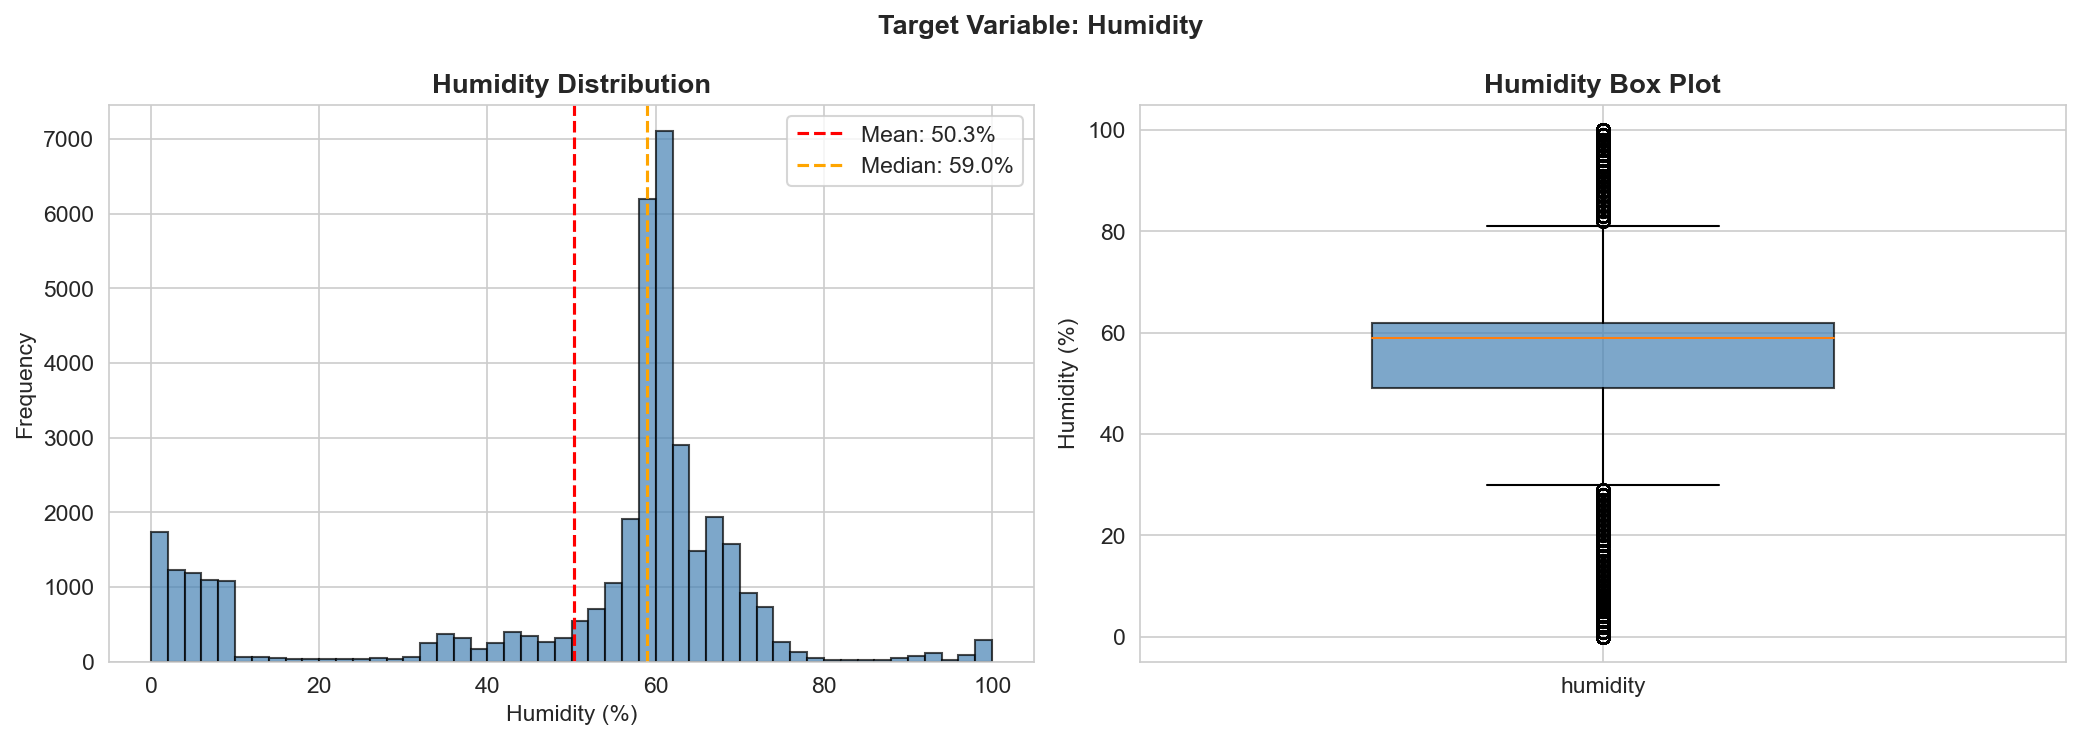

Humidity stats:
  Range: 0 - 100%
  Mean:  50.3%
  Std:   23.0%


In [5]:
# Visualization 1: target variable (humidity) distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram
axes[0].hist(df['humidity'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['humidity'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["humidity"].mean():.1f}%')
axes[0].axvline(df['humidity'].median(), color='orange', linestyle='--', 
                label=f'Median: {df["humidity"].median():.1f}%')
axes[0].set_xlabel('Humidity (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Humidity Distribution', fontweight='bold')
axes[0].legend()

# box plot
bp = axes[1].boxplot(df['humidity'], patch_artist=True, vert=True, widths=0.5)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
axes[1].set_ylabel('Humidity (%)')
axes[1].set_title('Humidity Box Plot', fontweight='bold')
axes[1].set_xticklabels(['humidity'])

plt.suptitle('Target Variable: Humidity', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('humidity_distribution.png', bbox_inches='tight')
plt.show()

print(f'Humidity stats:')
print(f'  Range: {df["humidity"].min()} - {df["humidity"].max()}%')
print(f'  Mean:  {df["humidity"].mean():.1f}%')
print(f'  Std:   {df["humidity"].std():.1f}%')

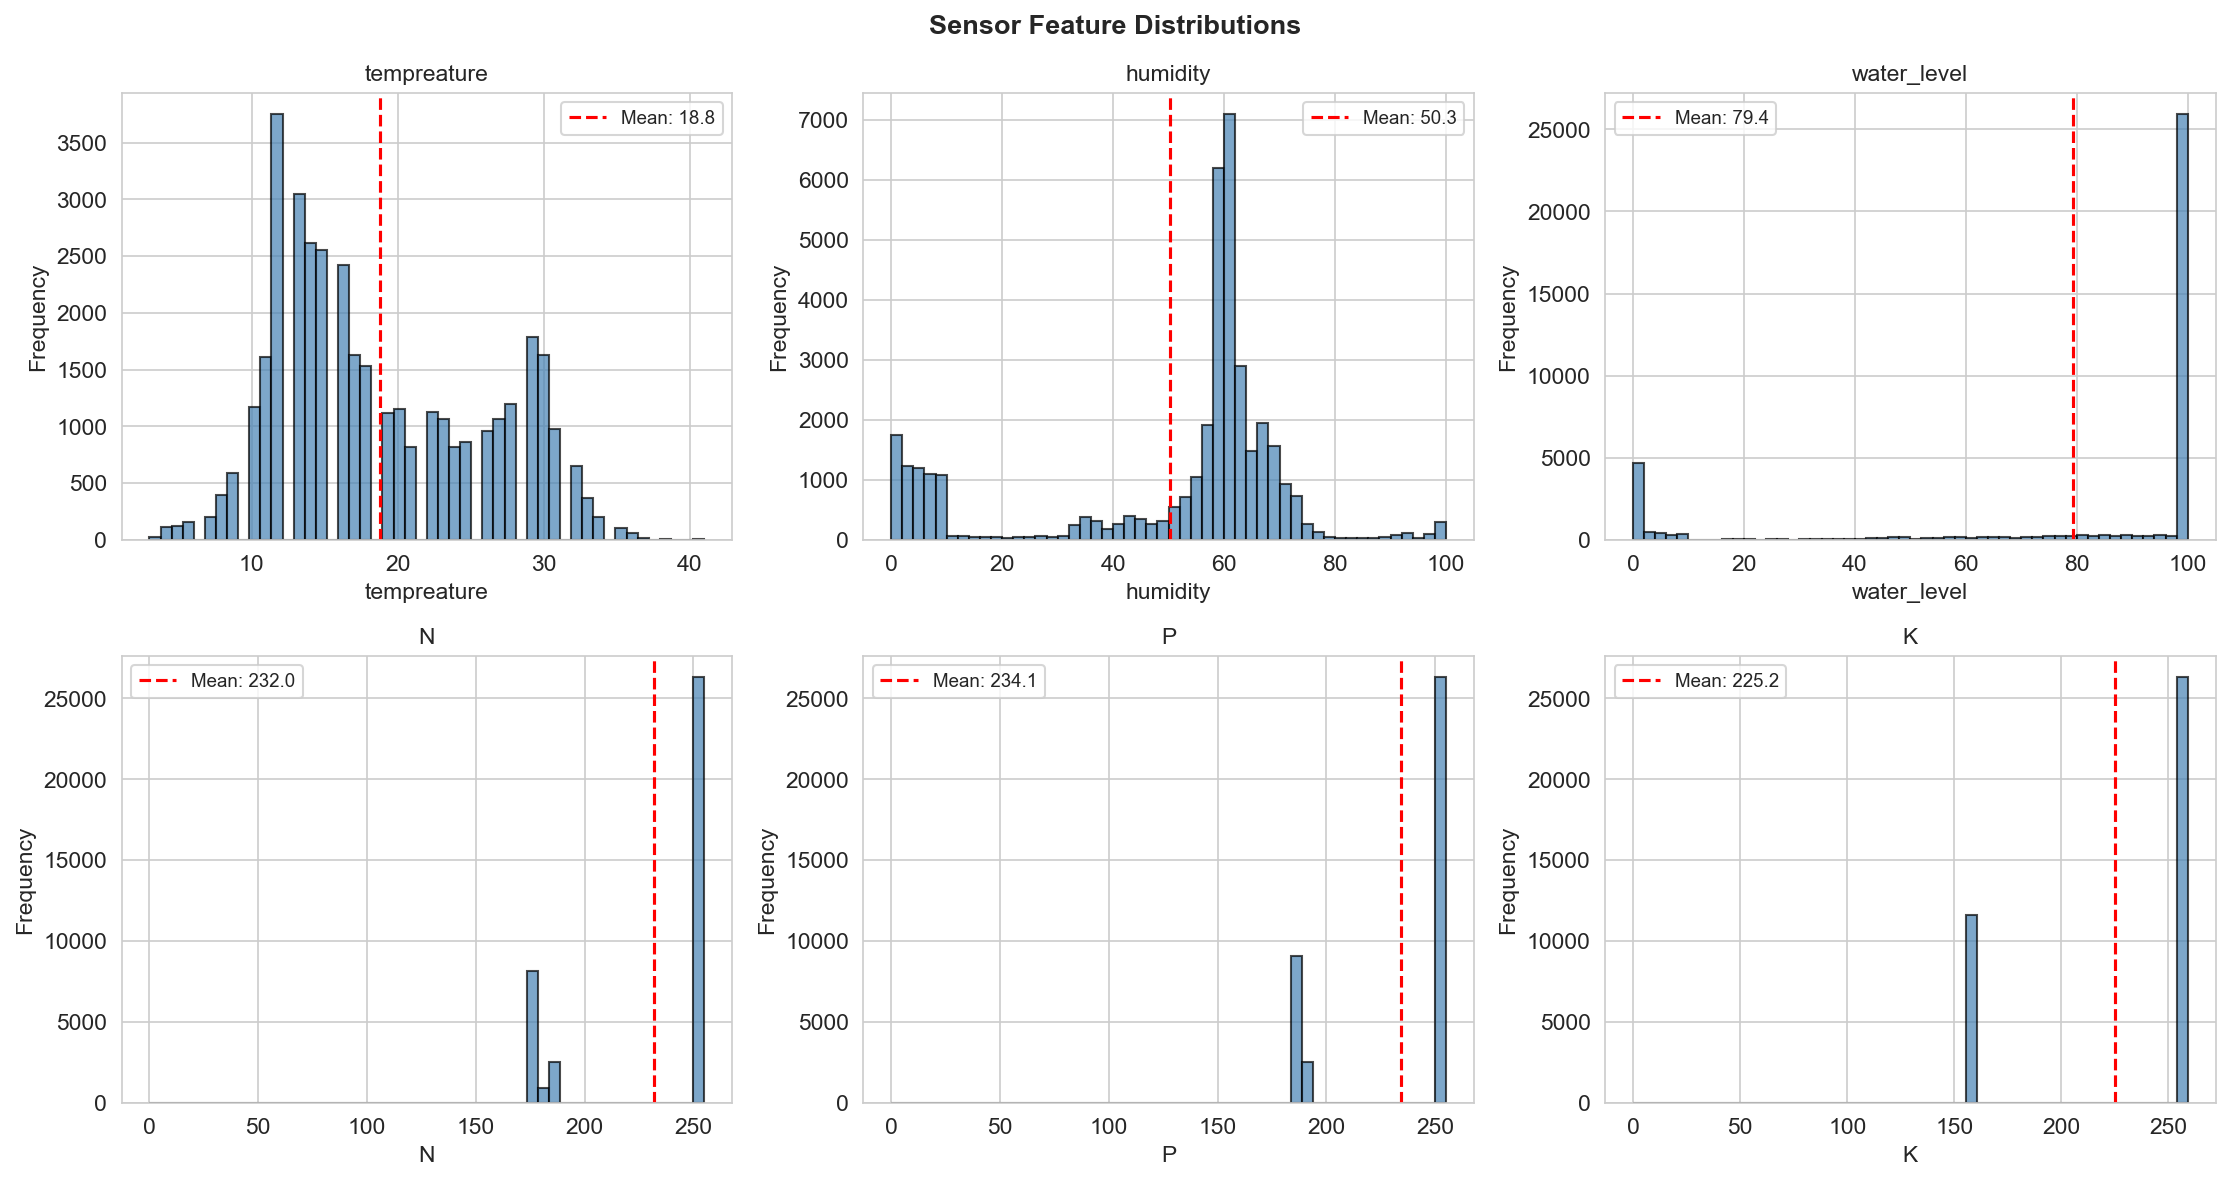

In [6]:
# Visualization 2: all sensor feature distributions
sensor_cols = ['tempreature', 'humidity', 'water_level', 'N', 'P', 'K']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(sensor_cols):
    axes[idx].hist(df[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=11)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    
    # add mean line
    mean_val = df[col].mean()
    axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    axes[idx].legend(fontsize=9)

plt.suptitle('Sensor Feature Distributions', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('sensor_distributions.png', bbox_inches='tight')
plt.show()

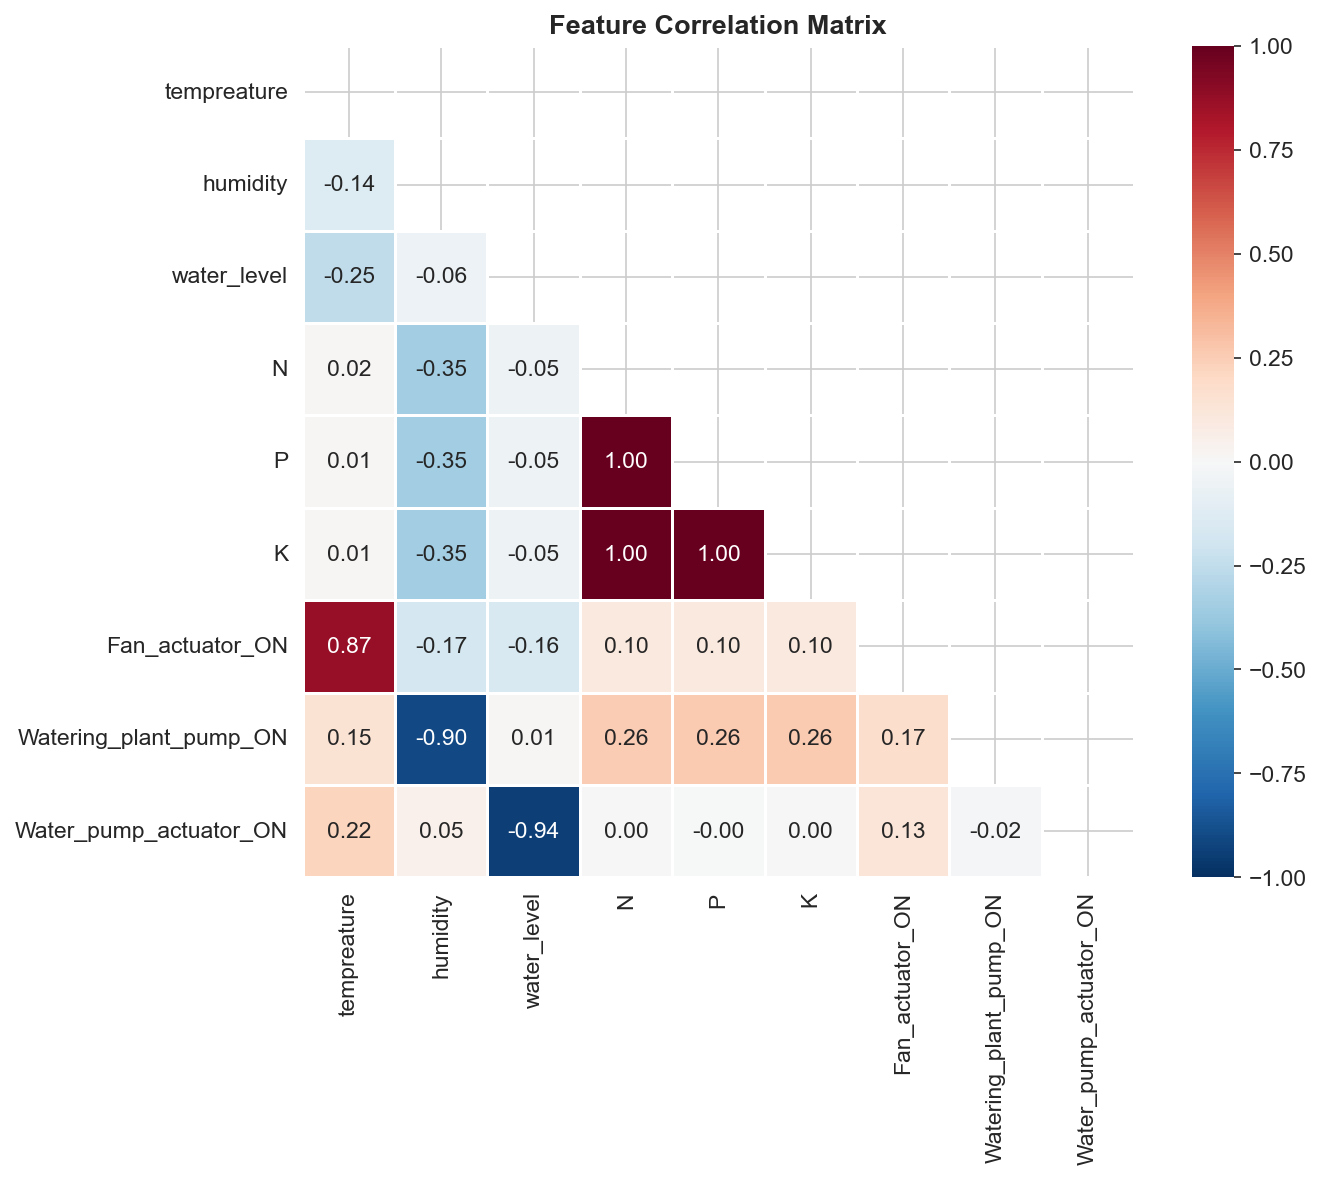


Correlations with humidity:
  Watering_plant_pump_ON        : -0.903
  K                             : -0.351
  P                             : -0.350
  N                             : -0.350
  Fan_actuator_ON               : -0.174
  tempreature                   : -0.139
  water_level                   : -0.059
  Water_pump_actuator_ON        : +0.049


In [7]:
# Visualization 3: correlation matrix
# using all numeric columns to see how everything relates to humidity
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', bbox_inches='tight')
plt.show()

# print correlations with humidity specifically
print('\nCorrelations with humidity:')
target_corr = corr_matrix['humidity'].drop('humidity').sort_values(key=abs, ascending=False)
for feat, corr in target_corr.items():
    print(f'  {feat:30s}: {corr:+.3f}')

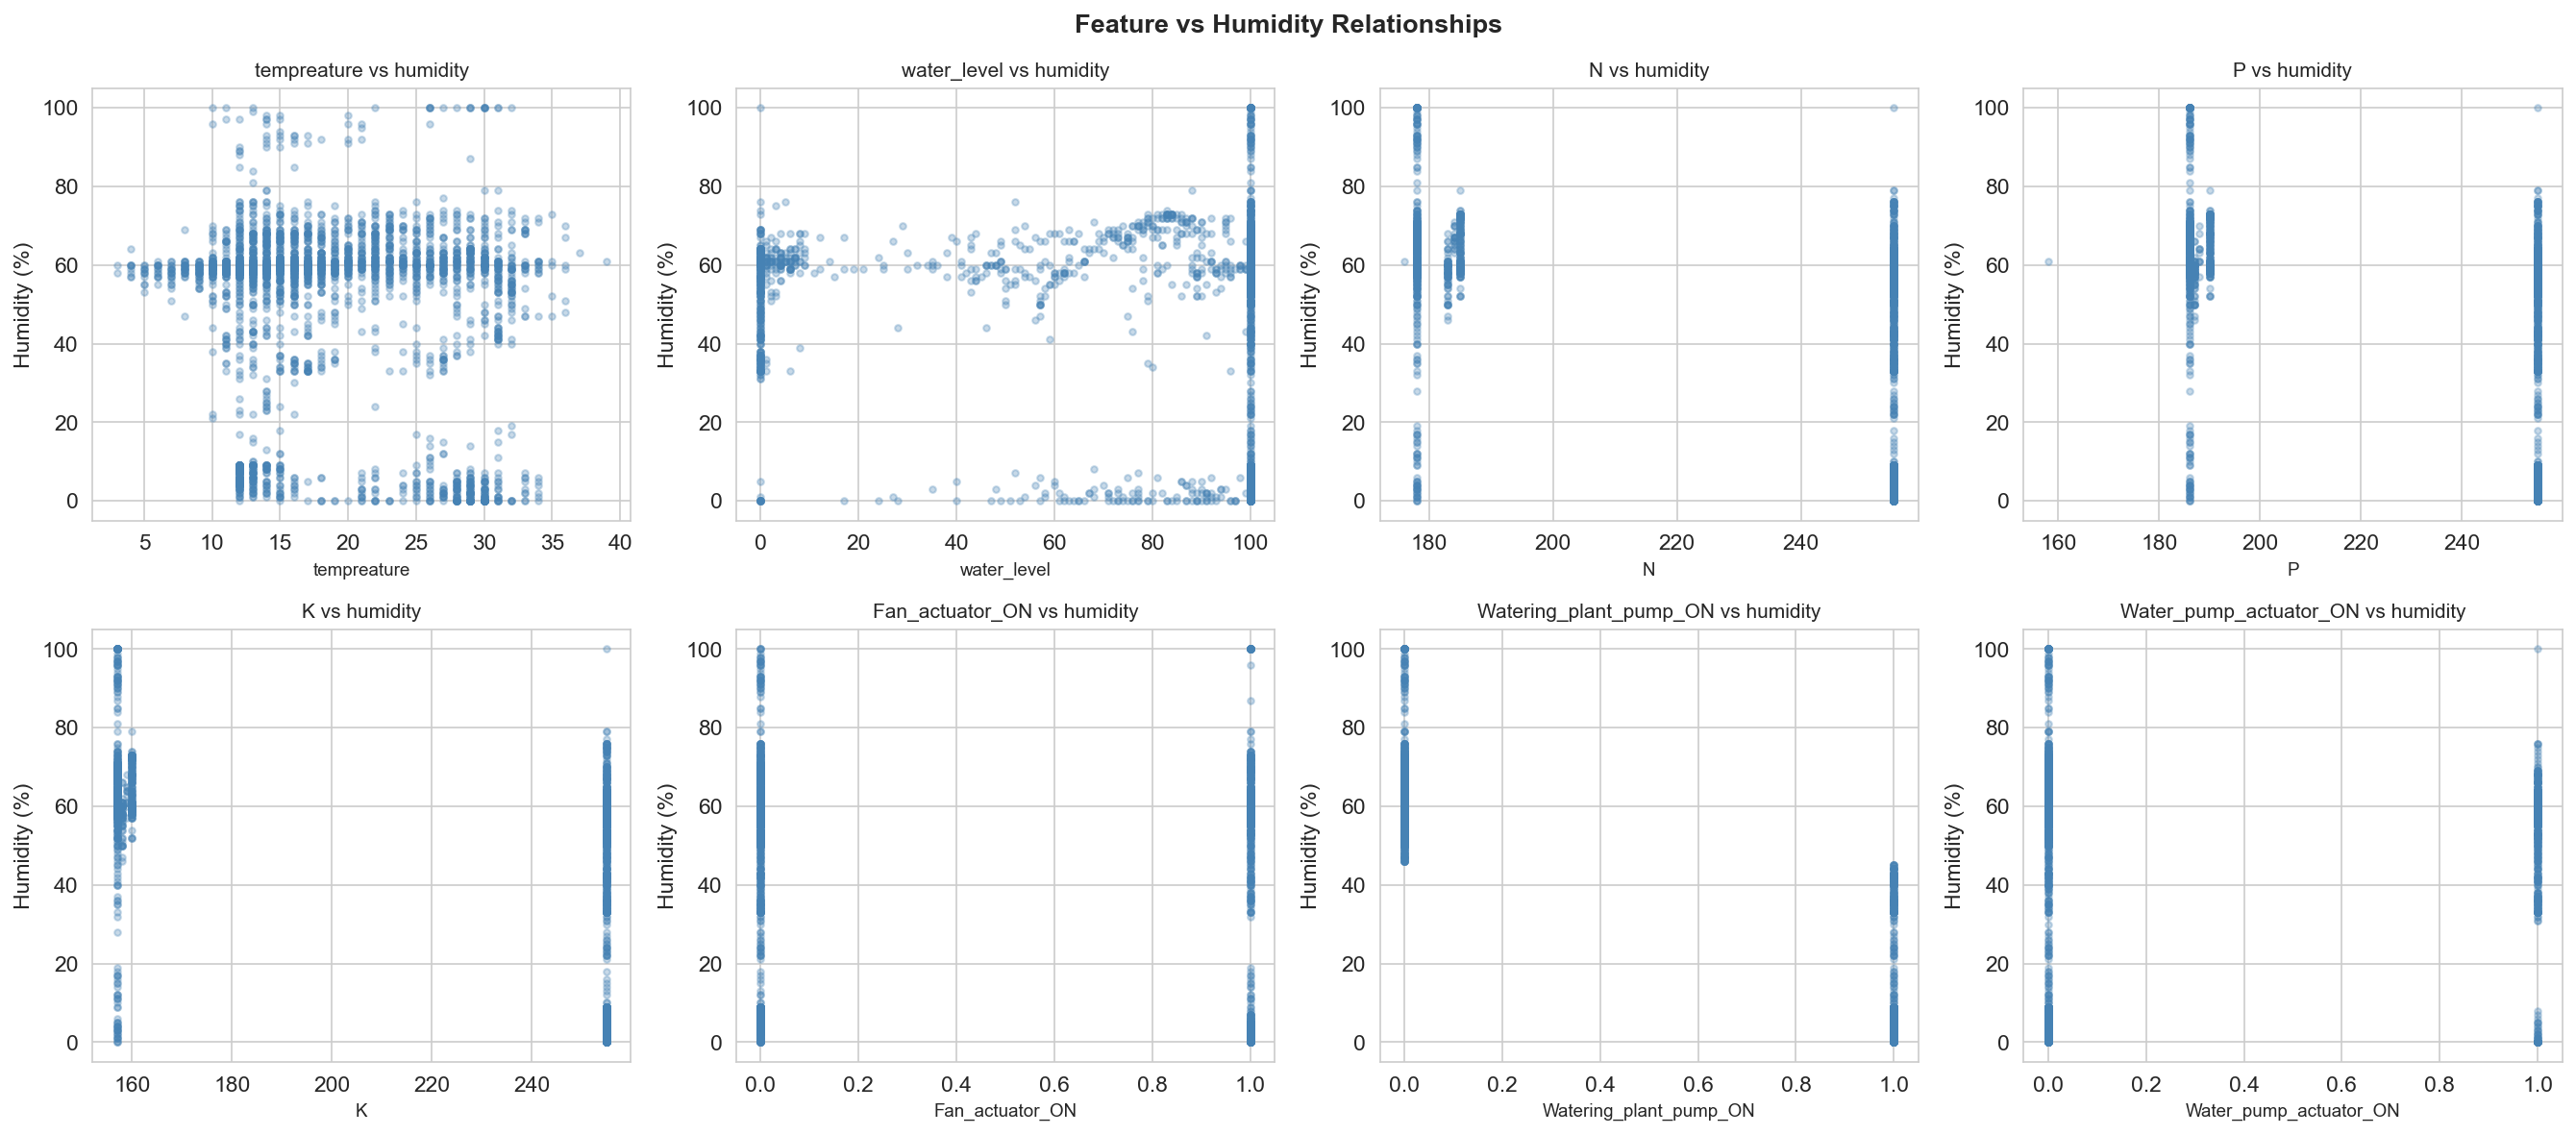

In [8]:
# Visualization 4: scatter plots of each feature vs humidity
# this shows us the relationship each feature has with our target
feature_cols = ['tempreature', 'water_level', 'N', 'P', 'K', 
                'Fan_actuator_ON', 'Watering_plant_pump_ON', 'Water_pump_actuator_ON']

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    # use a sample for scatter to avoid overplotting
    sample = df.sample(n=min(3000, len(df)), random_state=42)
    axes[idx].scatter(sample[col], sample['humidity'], alpha=0.3, s=10, color='steelblue')
    axes[idx].set_xlabel(col, fontsize=9)
    axes[idx].set_ylabel('Humidity (%)')
    axes[idx].set_title(f'{col} vs humidity', fontsize=10)

plt.suptitle('Feature vs Humidity Relationships', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('features_vs_humidity.png', bbox_inches='tight')
plt.show()

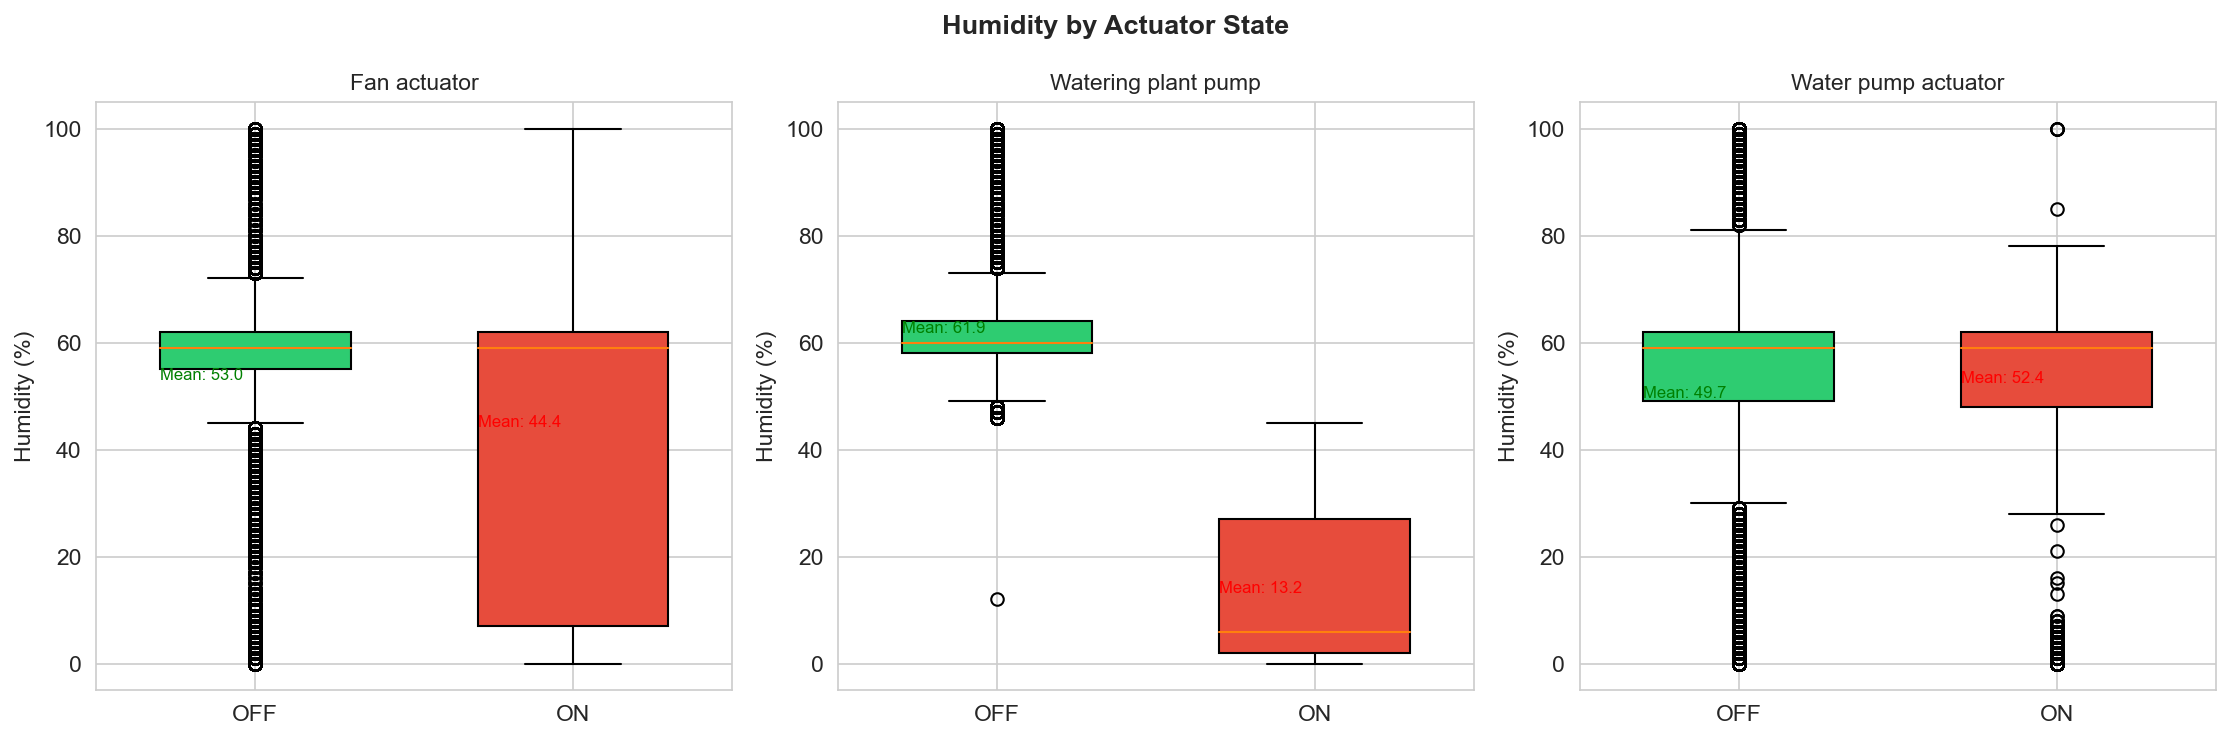

In [9]:
# Visualization 5: humidity by actuator states
# how does humidity differ when actuators are on vs off?
actuator_on_cols = ['Fan_actuator_ON', 'Watering_plant_pump_ON', 'Water_pump_actuator_ON']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(actuator_on_cols):
    data_off = df[df[col] == 0]['humidity']
    data_on = df[df[col] == 1]['humidity']
    
    bp = axes[idx].boxplot([data_off, data_on], labels=['OFF', 'ON'],
                           patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    name = col.replace('_ON', '').replace('_', ' ')
    axes[idx].set_title(f'{name}', fontsize=11)
    axes[idx].set_ylabel('Humidity (%)')
    
    # add mean annotations
    axes[idx].text(0.7, data_off.mean(), f'Mean: {data_off.mean():.1f}', fontsize=8, color='green')
    axes[idx].text(1.7, data_on.mean(), f'Mean: {data_on.mean():.1f}', fontsize=8, color='red')

plt.suptitle('Humidity by Actuator State', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('humidity_by_actuator.png', bbox_inches='tight')
plt.show()

## Data Preparation

Setting up features and target for the XGBoost regressor. I'm using all the available sensor readings and actuator states as features to predict humidity. The actuator states are included because they directly affect the greenhouse environment — fans reduce humidity, watering increases it — so they should be useful predictors.

Using an 80/20 train/test split to stay consistent with our other models.

In [10]:
# define features and target
feature_cols = ['tempreature', 'water_level', 'N', 'P', 'K', 
                'Fan_actuator_ON', 'Watering_plant_pump_ON', 'Water_pump_actuator_ON']
target_col = 'humidity'

X = df[feature_cols].copy()
y = df[target_col].copy()

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nTarget stats:')
print(f'  Mean: {y.mean():.2f}')
print(f'  Std:  {y.std():.2f}')
print(f'  Min:  {y.min()}')
print(f'  Max:  {y.max()}')

# sanity check
assert X.shape[0] == y.shape[0], 'Feature and target row counts dont match!'
assert X.isnull().sum().sum() == 0, 'Unexpected missing values in features!'
print('\nData looks clean - no missing values, shapes match')

Features shape: (37920, 8)
Target shape: (37920,)

Target stats:
  Mean: 50.33
  Std:  23.00
  Min:  0
  Max:  100

Data looks clean - no missing values, shapes match


In [11]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f'Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.0f}%)')

# check that train/test have similar target distributions
print(f'\nTrain humidity - mean: {y_train.mean():.1f}, std: {y_train.std():.1f}')
print(f'Test humidity  - mean: {y_test.mean():.1f}, std: {y_test.std():.1f}')

Train: 30336 samples (80%)
Test:  7584 samples (20%)

Train humidity - mean: 50.2, std: 23.1
Test humidity  - mean: 50.7, std: 22.7


In [12]:
# scale features - XGBoost doesn't strictly need this since it uses tree splits,
# but it helps keep things consistent and makes feature importance more comparable
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=feature_cols, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=feature_cols, 
    index=X_test.index
)

print('Feature scaling applied (StandardScaler)')
print(f'Train means (should be ~0): {X_train_scaled.mean().values.round(2)}')
print(f'Train stds (should be ~1):  {X_train_scaled.std().values.round(2)}')

Feature scaling applied (StandardScaler)
Train means (should be ~0): [ 0.  0. -0. -0. -0.  0. -0.  0.]
Train stds (should be ~1):  [1. 1. 1. 1. 1. 1. 1. 1.]


## Build XGBoost Regressor

XGBoost (eXtreme Gradient Boosting) works by building decision trees one after another, where each new tree tries to fix the mistakes of the ones before it. Using the regressor version since humidity is continuous (0-100%).

Quick note on the main hyperparameters:
- `n_estimators` = number of trees (kind of like epochs in neural networks)
- `max_depth` = how deep each tree can grow (controls complexity)
- `learning_rate` = how much each tree contributes (lower = more conservative)
- `subsample` and `colsample_bytree` = adds randomness to reduce overfitting

In [13]:
# build the XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,           # use 80% of data per tree (reduces overfitting)
    colsample_bytree=0.8,    # use 80% of features per tree
    reg_alpha=0.1,           # L1 regularization
    reg_lambda=1.0,          # L2 regularization
    random_state=1234,       # same seed pattern as LSTM notebook
    n_jobs=-1                # use all CPU cores
)

# train with evaluation set to monitor overfitting
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=50  # print every 50 rounds
)

print('\nTraining complete!')

[0]	validation_0-rmse:49.47193	validation_1-rmse:49.67268


[50]	validation_0-rmse:7.13445	validation_1-rmse:7.19260


[100]	validation_0-rmse:7.05078	validation_1-rmse:7.14831


[150]	validation_0-rmse:7.02617	validation_1-rmse:7.14463


[200]	validation_0-rmse:7.01126	validation_1-rmse:7.15255


[250]	validation_0-rmse:7.00183	validation_1-rmse:7.15023


[299]	validation_0-rmse:6.99547	validation_1-rmse:7.15188



Training complete!


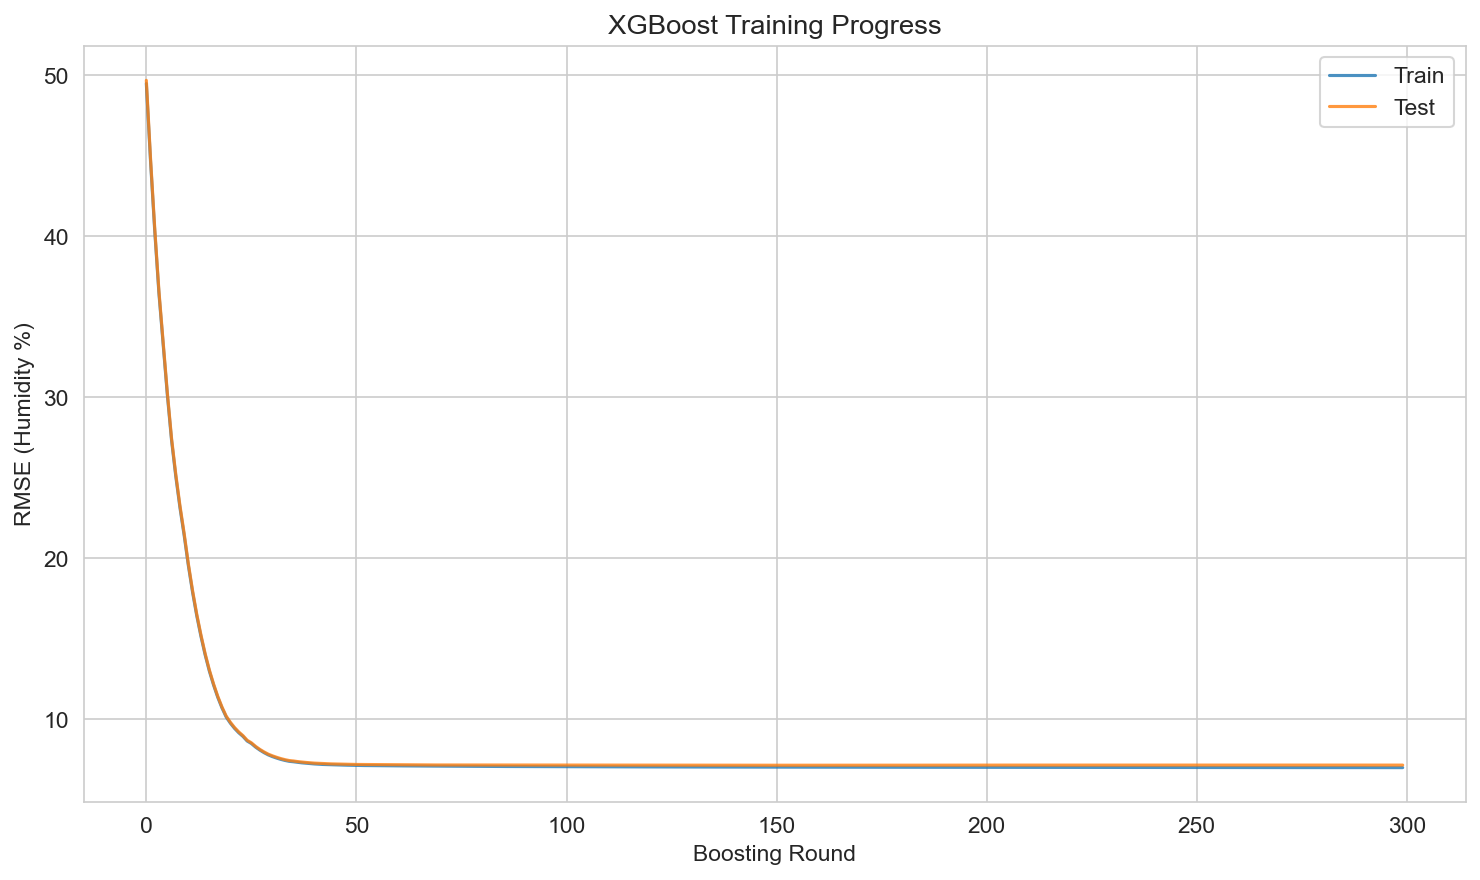

Final train RMSE: 6.9955
Final test RMSE:  7.1519
Gap: 0.1564 (looks fine)


In [14]:
# Visualization 6: learning curves (mirrors LSTM loss curve pattern)
results = model.evals_result()

fig = plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Train', alpha=0.8)
plt.plot(results['validation_1']['rmse'], label='Test', alpha=0.8)
plt.title('XGBoost Training Progress')
plt.ylabel('RMSE (Humidity %)')
plt.xlabel('Boosting Round')
plt.legend()
plt.tight_layout()
plt.savefig('xgboost_learning_curves.png', bbox_inches='tight')
plt.show()

# check for overfitting
final_train = results['validation_0']['rmse'][-1]
final_test = results['validation_1']['rmse'][-1]
print(f'Final train RMSE: {final_train:.4f}')
print(f'Final test RMSE:  {final_test:.4f}')
gap = abs(final_test - final_train)
print(f'Gap: {gap:.4f} {"(looks fine)" if gap < 2.0 else "(some overfitting)"}')

## Model Evaluation

Looking at a few different regression metrics here:
- **RMSE** — average error in humidity percentage points. Penalizes big misses more than small ones
- **MAE** — average absolute error, more robust to outliers than RMSE
- **R-squared** — how much variance the model explains (1.0 = perfect, 0.0 = no better than just predicting the mean)

In [15]:
# generate predictions
y_pred = model.predict(X_test_scaled)

# regression metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('='*50)
print('Model Performance')
print('='*50)
print(f'RMSE: {rmse:.2f}% humidity')
print(f'MAE:  {mae:.2f}% humidity')
print(f'MSE:  {mse:.2f}')
print(f'R²:   {r2:.4f}')
print(f'\nInterpretation:')
print(f'  The model explains {r2*100:.1f}% of the variance in humidity.')
print(f'  On average, predictions are off by {mae:.1f}% humidity.')

# sanity check
assert len(y_pred) == len(y_test), 'Prediction count mismatch!'
print('\nPredictions verified')

Model Performance
RMSE: 7.15% humidity
MAE:  4.06% humidity
MSE:  51.15
R²:   0.9006

Interpretation:
  The model explains 90.1% of the variance in humidity.
  On average, predictions are off by 4.1% humidity.

Predictions verified


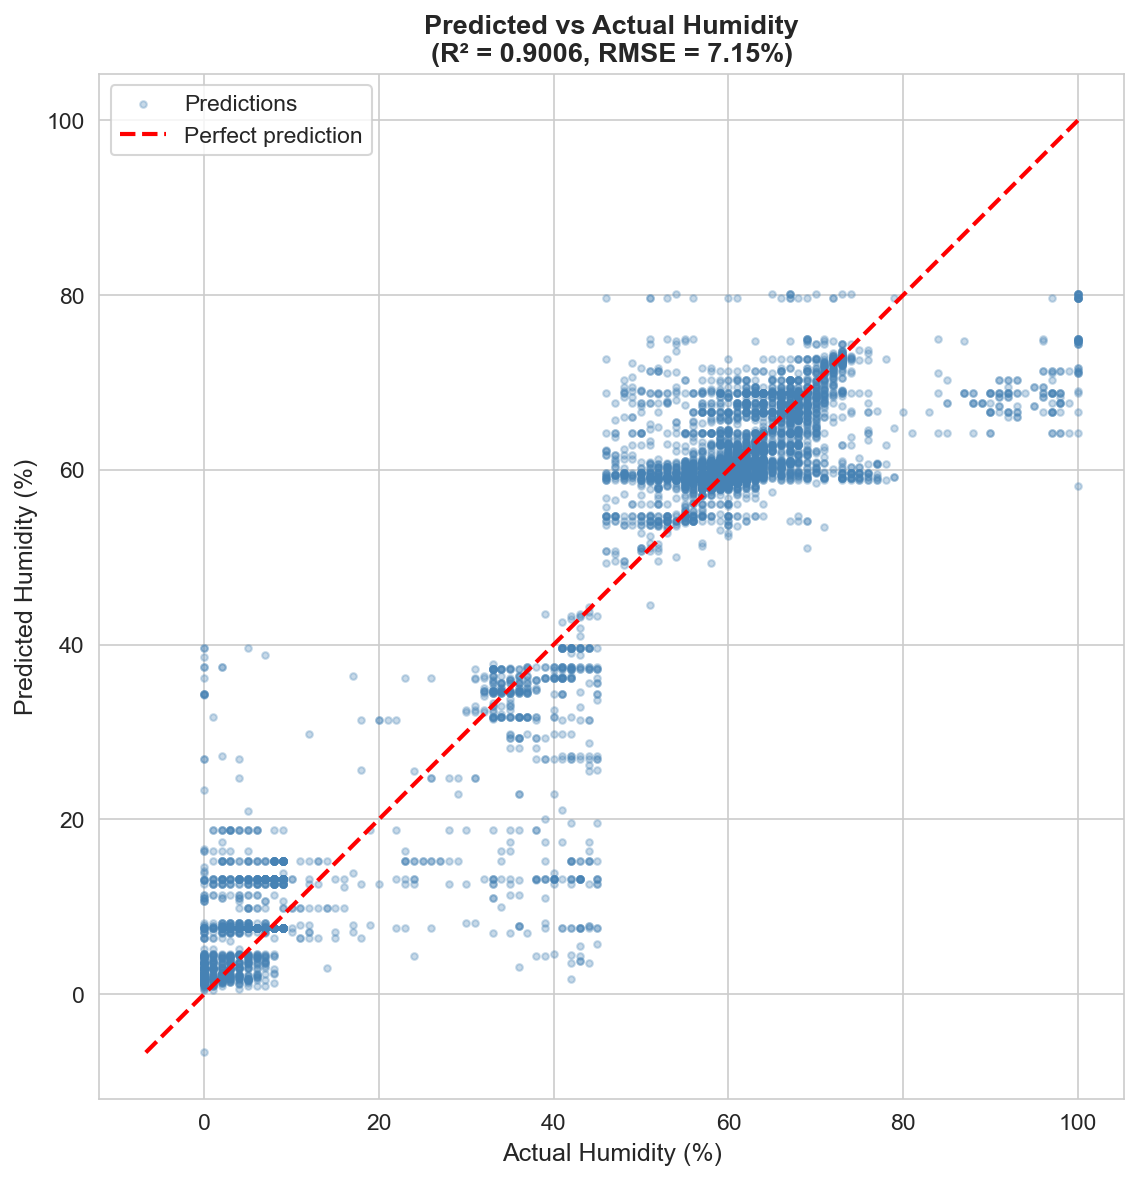

In [16]:
# Visualization 7: predicted vs actual scatter plot
# this is the key regression evaluation plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_test, y_pred, alpha=0.3, s=10, color='steelblue', label='Predictions')

# perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

ax.set_xlabel('Actual Humidity (%)', fontsize=12)
ax.set_ylabel('Predicted Humidity (%)', fontsize=12)
ax.set_title(f'Predicted vs Actual Humidity\n(R² = {r2:.4f}, RMSE = {rmse:.2f}%)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('predicted_vs_actual.png', bbox_inches='tight')
plt.show()

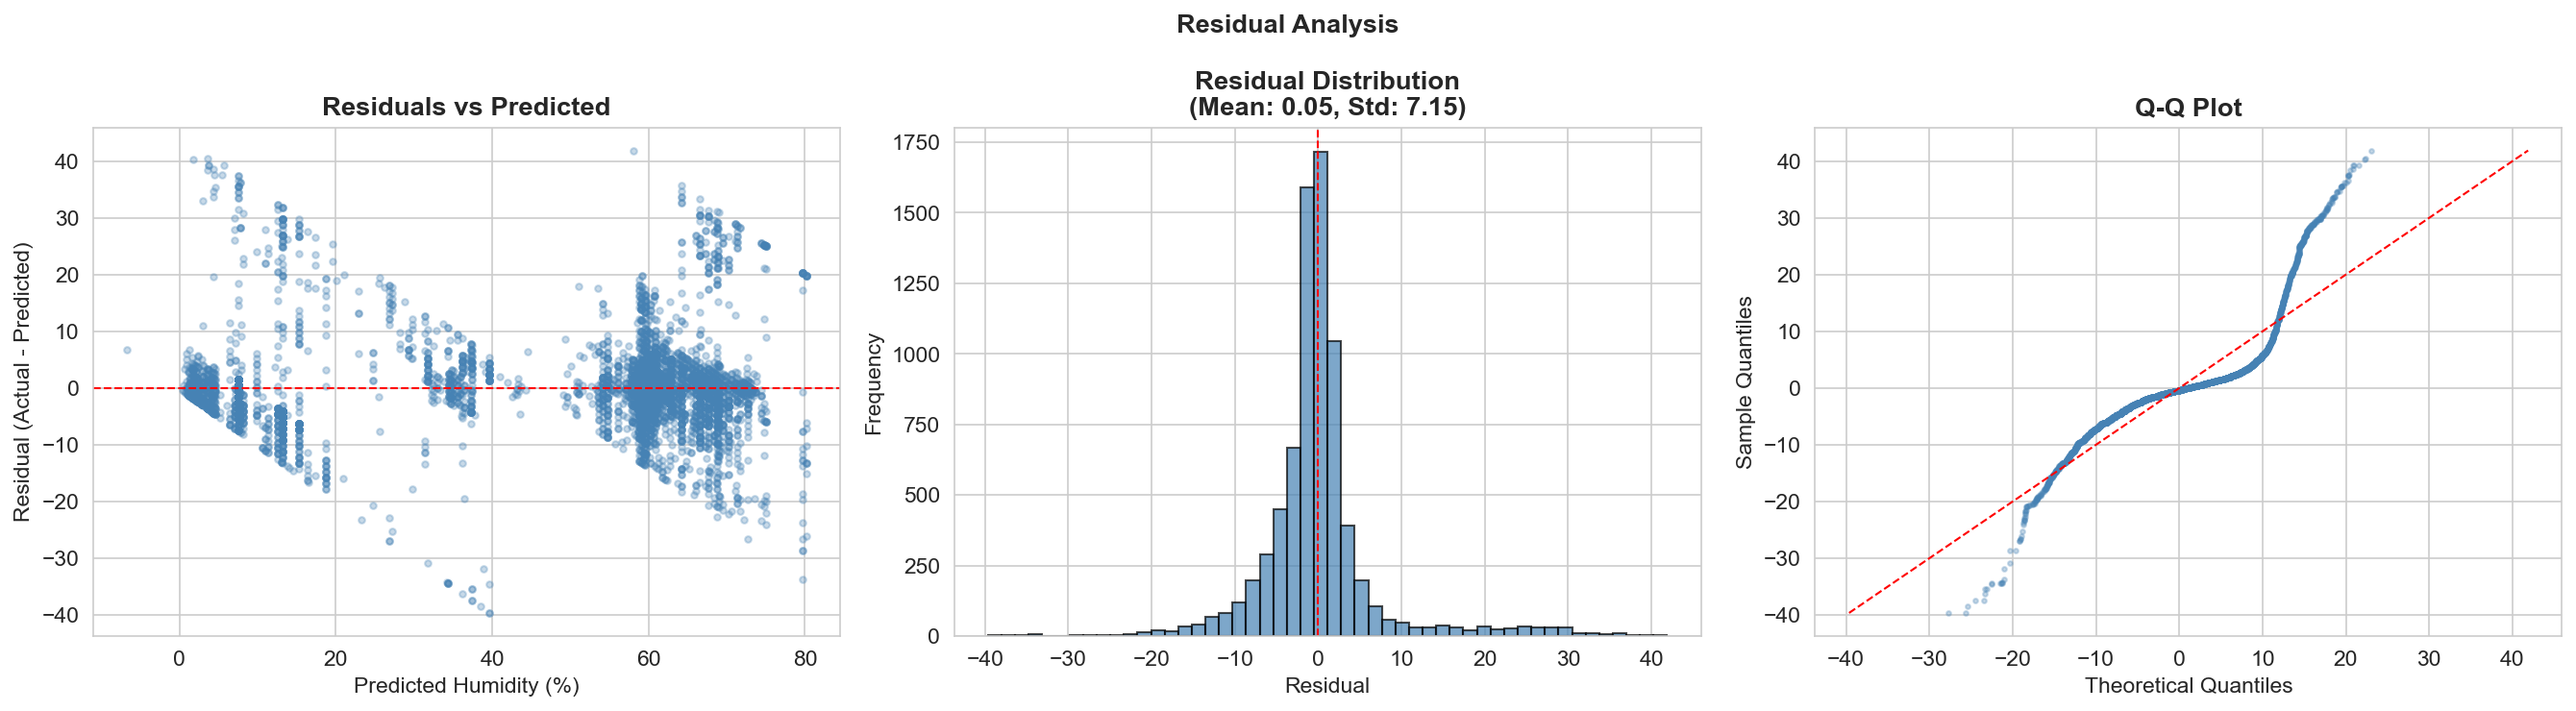

In [17]:
# Visualization 8: residual analysis
residuals = y_test.values - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# residuals vs predicted
axes[0].scatter(y_pred, residuals, alpha=0.3, s=10, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', lw=1)
axes[0].set_xlabel('Predicted Humidity (%)')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].set_title('Residuals vs Predicted', fontweight='bold')

# residual distribution
axes[1].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=1)
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual Distribution\n(Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f})', 
                  fontweight='bold')

# QQ-style: sorted residuals
sorted_res = np.sort(residuals)
theoretical = np.random.normal(residuals.mean(), residuals.std(), len(residuals))
theoretical = np.sort(theoretical)
axes[2].scatter(theoretical, sorted_res, alpha=0.3, s=5, color='steelblue')
axes[2].plot([sorted_res.min(), sorted_res.max()], [sorted_res.min(), sorted_res.max()], 
             'r--', lw=1)
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Sample Quantiles')
axes[2].set_title('Q-Q Plot', fontweight='bold')

plt.suptitle('Residual Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('residual_analysis.png', bbox_inches='tight')
plt.show()

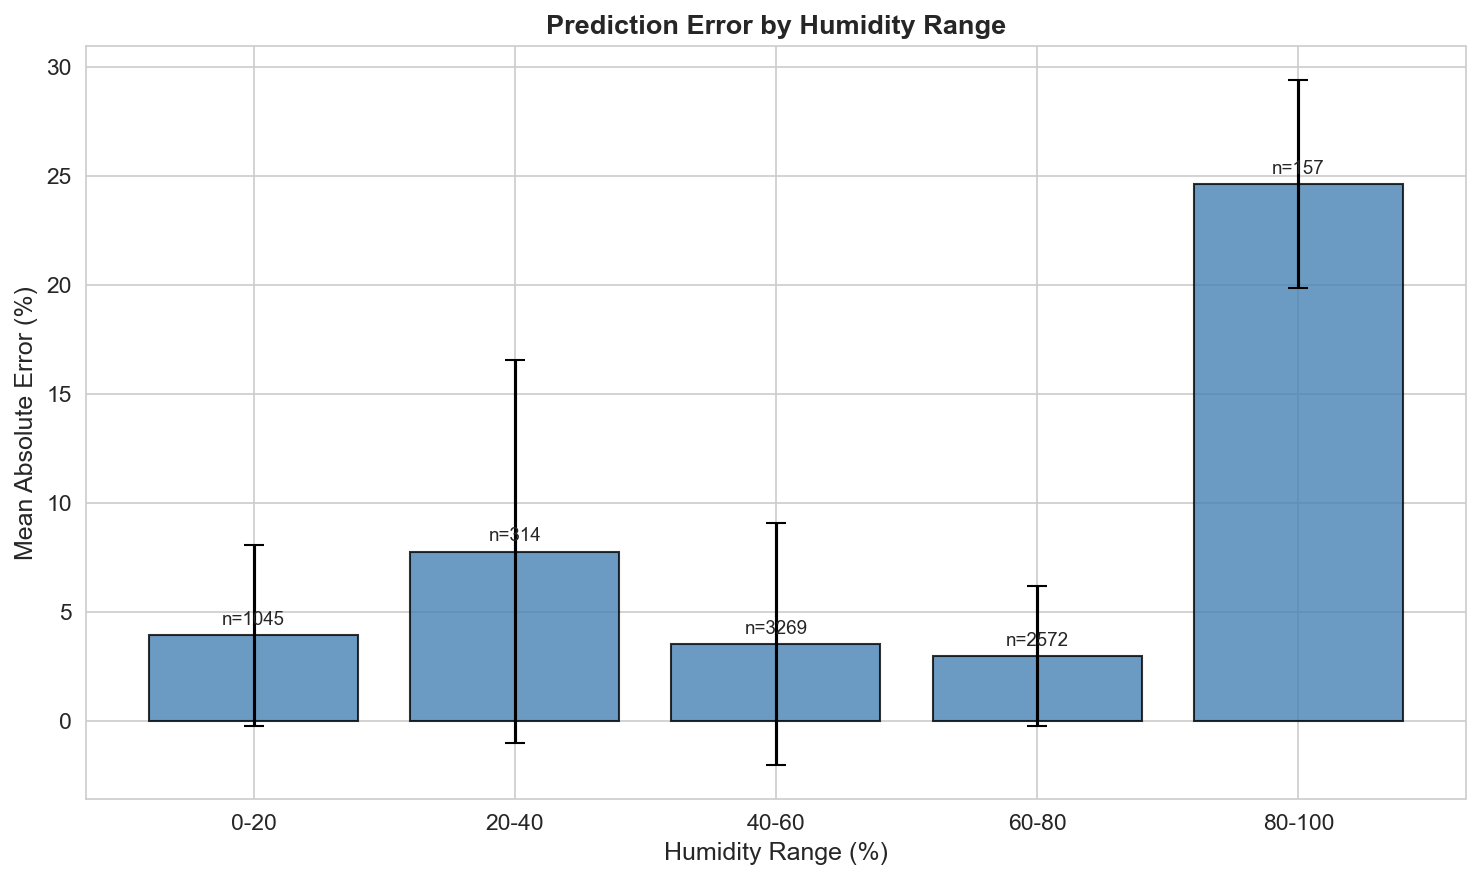

In [18]:
# Visualization 9: prediction error by humidity range
# are we better at predicting certain humidity levels?
error_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'abs_error': np.abs(residuals)
})

# bin humidity into ranges
error_df['humidity_range'] = pd.cut(error_df['actual'], 
                                     bins=[0, 20, 40, 60, 80, 100],
                                     labels=['0-20', '20-40', '40-60', '60-80', '80-100'])

fig, ax = plt.subplots(figsize=(10, 6))
range_errors = error_df.groupby('humidity_range')['abs_error'].agg(['mean', 'std', 'count'])

bars = ax.bar(range_errors.index, range_errors['mean'], 
              yerr=range_errors['std'], capsize=5,
              color='steelblue', edgecolor='black', alpha=0.8)

# add count labels
for bar, count in zip(bars, range_errors['count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'n={int(count)}', ha='center', fontsize=9)

ax.set_xlabel('Humidity Range (%)', fontsize=12)
ax.set_ylabel('Mean Absolute Error (%)', fontsize=12)
ax.set_title('Prediction Error by Humidity Range', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('error_by_range.png', bbox_inches='tight')
plt.show()

## Feature Importance Analysis

One of the big advantages XGBoost has over neural networks is interpretability — we can see exactly which sensors matter most for predicting humidity. This is useful in an IoT context because if a sensor breaks, you know how much that impacts predictions. You can also potentially reduce costs by dropping sensors that don't contribute much, and domain experts can validate whether the model's priorities make physical sense.

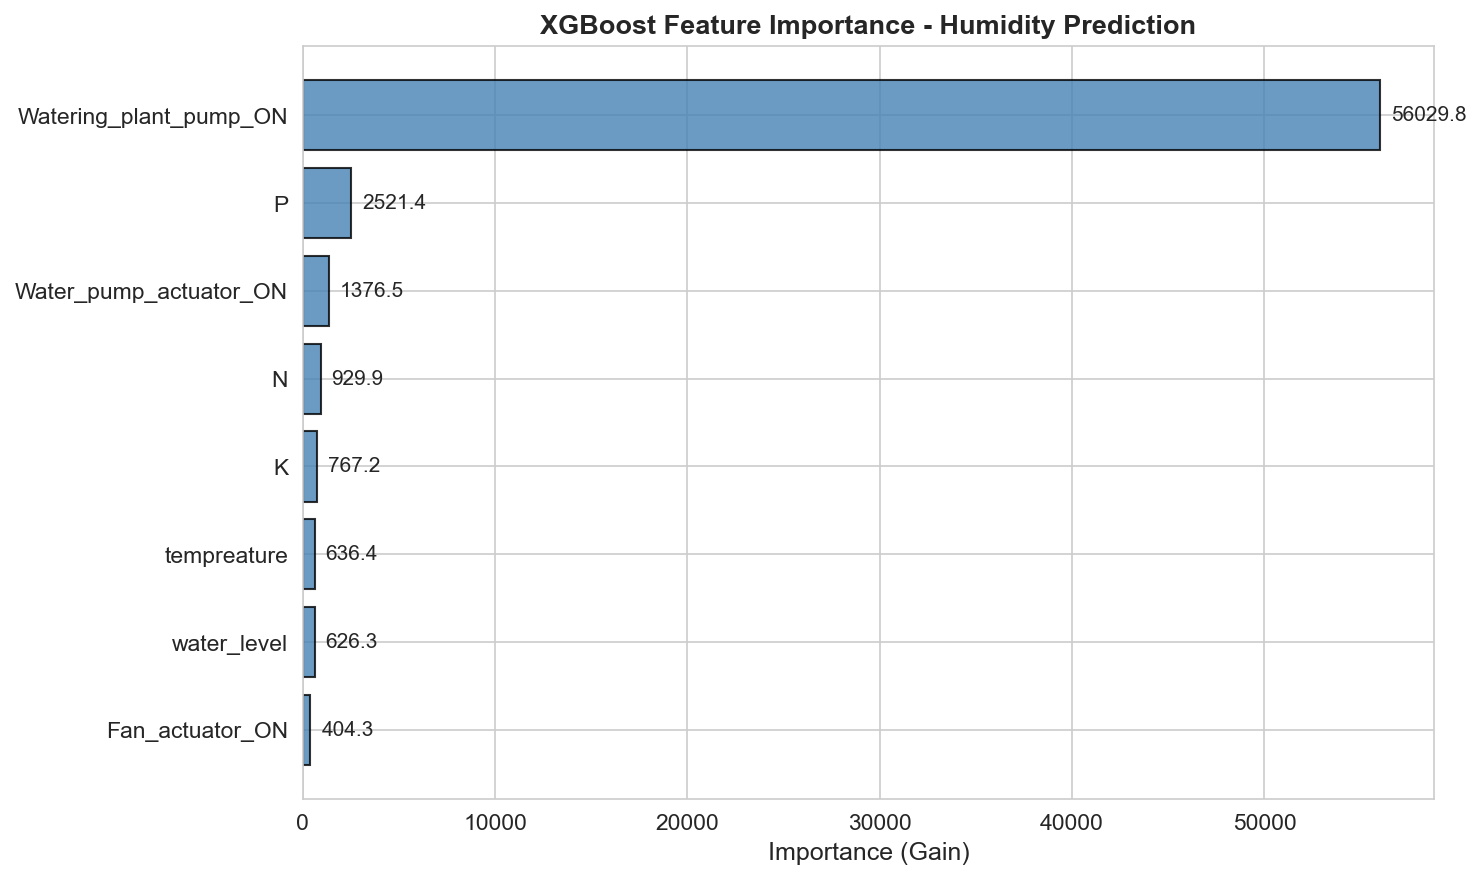


Feature Importance Rankings:
----------------------------------------
  Watering_plant_pump_ON        : 56029.82
  P                             : 2521.36
  Water_pump_actuator_ON        : 1376.47
  N                             : 929.90
  K                             : 767.25
  tempreature                   : 636.35
  water_level                   : 626.34
  Fan_actuator_ON               : 404.30


In [19]:
# Visualization 10: feature importance (gain-based)
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(importance_df['Feature'], importance_df['Importance'], 
               color='steelblue', edgecolor='black', alpha=0.8)
ax.set_xlabel('Importance (Gain)', fontsize=12)
ax.set_title('XGBoost Feature Importance - Humidity Prediction', fontsize=13, fontweight='bold')

# add value labels on bars
for bar, val in zip(bars, importance_df['Importance']):
    ax.text(bar.get_width() + max(importance_df['Importance'])*0.01, 
            bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

# print rankings
print('\nFeature Importance Rankings:')
print('-' * 40)
for _, row in importance_df.sort_values('Importance', ascending=False).iterrows():
    print(f'  {row["Feature"]:30s}: {row["Importance"]:.2f}')

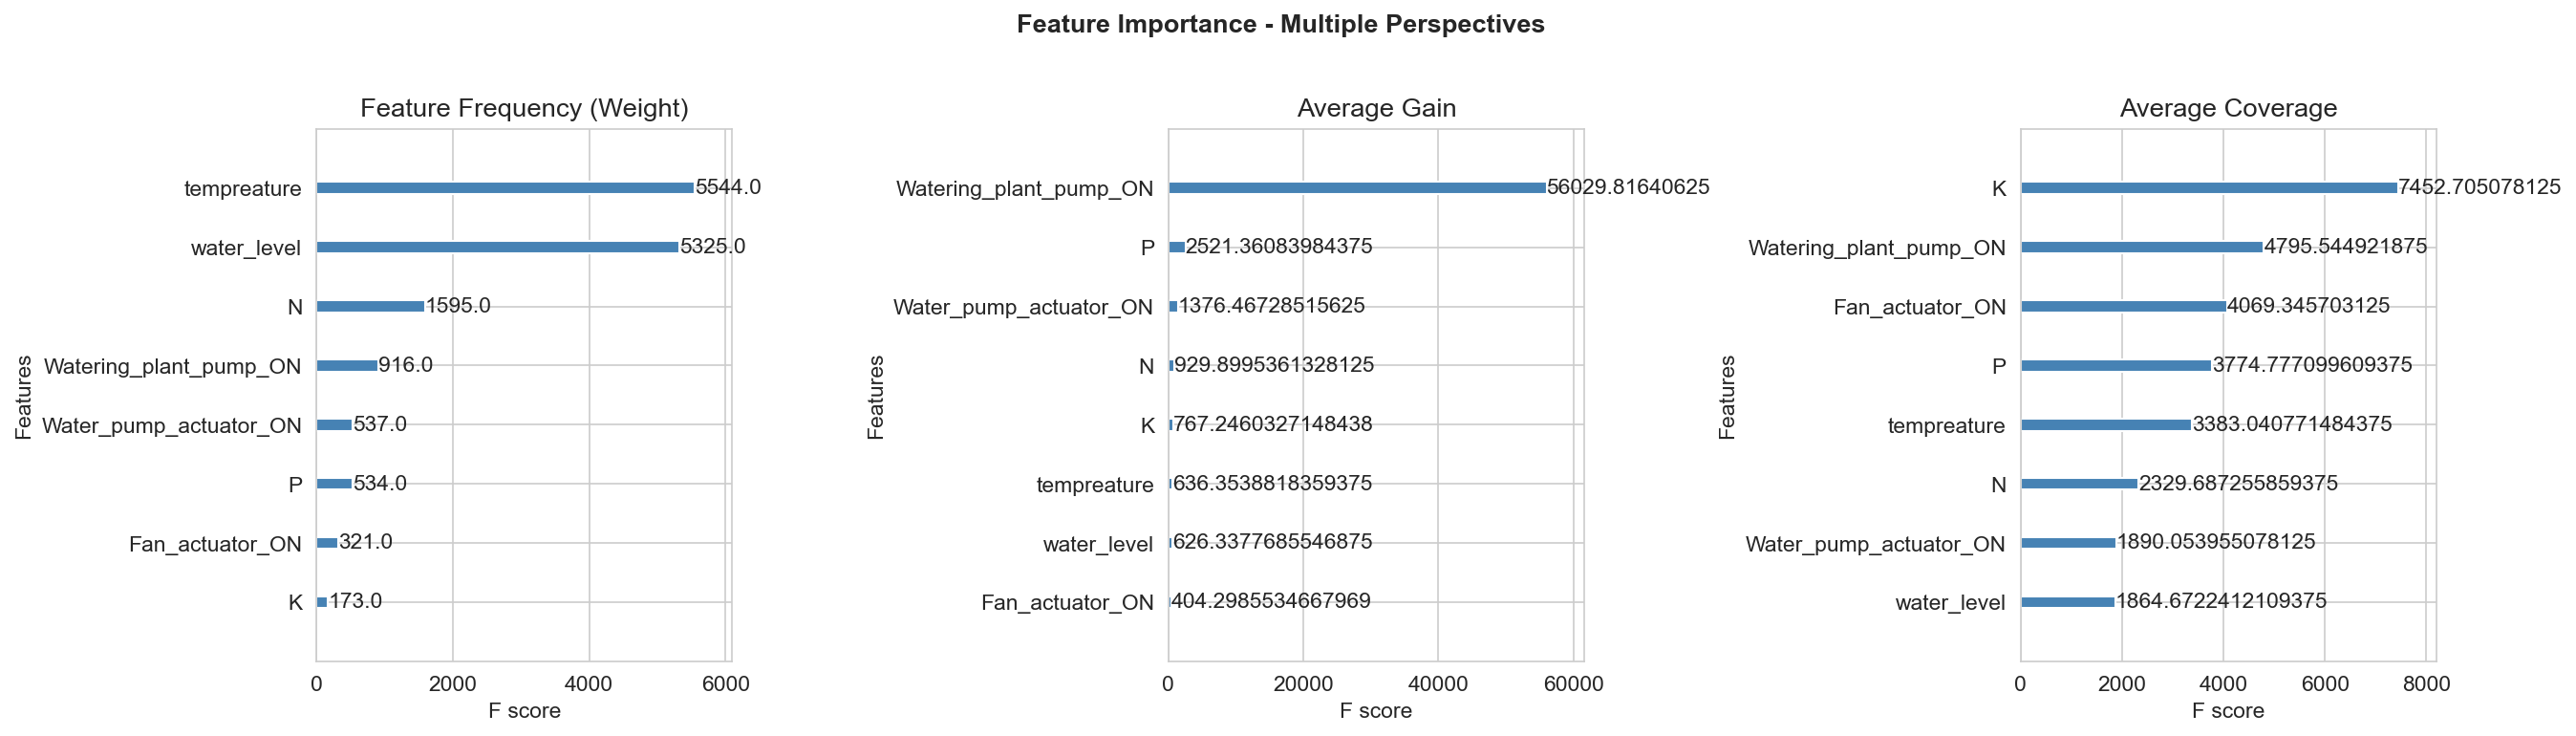

In [20]:
# Visualization 11: feature importance from multiple perspectives
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

importance_types = ['weight', 'gain', 'cover']
titles = ['Feature Frequency (Weight)', 'Average Gain', 'Average Coverage']

for ax, imp_type, title in zip(axes, importance_types, titles):
    xgb.plot_importance(model, importance_type=imp_type, ax=ax, 
                        title=title, color='steelblue')

plt.suptitle('Feature Importance - Multiple Perspectives', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_importance_multi.png', bbox_inches='tight')
plt.show()

## Save Model and Export Results

Saving the trained model and exporting the metrics/predictions so we can use them in the Tableau dashboard and group report.

In [21]:
# save the trained model
model_save_path = 'xgboost_humidity_model.json'
model.save_model(model_save_path)
print(f'Model saved to: {model_save_path}')

# verify we can reload it
model_loaded = xgb.XGBRegressor()
model_loaded.load_model(model_save_path)
y_pred_verify = model_loaded.predict(X_test_scaled)
assert np.allclose(y_pred, y_pred_verify), 'Loaded model gives different predictions!'
print('Model reload verified - predictions match')

# also save as pickle for sklearn compatibility
import joblib
joblib.dump(model, 'xgboost_humidity_model.pkl')
print('Also saved as pickle: xgboost_humidity_model.pkl')

# save the scaler too (needed for inference on new data)
joblib.dump(scaler, 'scaler_humidity_model.pkl')
print('Scaler saved: scaler_humidity_model.pkl')

Model saved to: xgboost_humidity_model.json
Model reload verified - predictions match
Also saved as pickle: xgboost_humidity_model.pkl
Scaler saved: scaler_humidity_model.pkl


In [22]:
# export a summary CSV for the Tableau dashboard
metrics_summary = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MSE', 'R_Squared',
               'Train_Samples', 'Test_Samples', 'Num_Features', 'Num_Trees',
               'Target_Mean', 'Target_Std'],
    'Value': [rmse, mae, mse, r2,
              len(X_train), len(X_test), len(feature_cols), model.n_estimators,
              y.mean(), y.std()]
})
metrics_summary.to_csv('xgboost_metrics_summary.csv', index=False)
print('Metrics exported to: xgboost_metrics_summary.csv')
print(metrics_summary.to_string(index=False))

Metrics exported to: xgboost_metrics_summary.csv
       Metric        Value
         RMSE     7.151881
          MAE     4.058203
          MSE    51.149404
    R_Squared     0.900614
Train_Samples 30336.000000
 Test_Samples  7584.000000
 Num_Features     8.000000
    Num_Trees   300.000000
  Target_Mean    50.329589
   Target_Std    22.996219


In [23]:
# export test predictions and feature importance for Tableau analysis
predictions_df = X_test.copy()
predictions_df['actual_humidity'] = y_test.values
predictions_df['predicted_humidity'] = y_pred
predictions_df['residual'] = residuals
predictions_df['abs_error'] = np.abs(residuals)
predictions_df.to_csv('xgboost_predictions.csv', index=False)
print(f'Predictions exported: xgboost_predictions.csv ({len(predictions_df)} rows)')

# export feature importance
importance_export = pd.DataFrame({
    'Feature': feature_cols,
    'Importance_Gain': [importance.get(f, 0) for f in feature_cols],
    'Importance_Normalized': model.feature_importances_
})
importance_export = importance_export.sort_values('Importance_Gain', ascending=False)
importance_export.to_csv('xgboost_feature_importance.csv', index=False)
print('Feature importance exported: xgboost_feature_importance.csv')
print(importance_export.to_string(index=False))

Predictions exported: xgboost_predictions.csv (7584 rows)
Feature importance exported: xgboost_feature_importance.csv
               Feature  Importance_Gain  Importance_Normalized
Watering_plant_pump_ON     56029.816406               0.885262
                     P      2521.360840               0.039837
Water_pump_actuator_ON      1376.467285               0.021748
                     N       929.899536               0.014692
                     K       767.246033               0.012122
           tempreature       636.353882               0.010054
           water_level       626.337769               0.009896
       Fan_actuator_ON       404.298553               0.006388


## Summary Dashboard

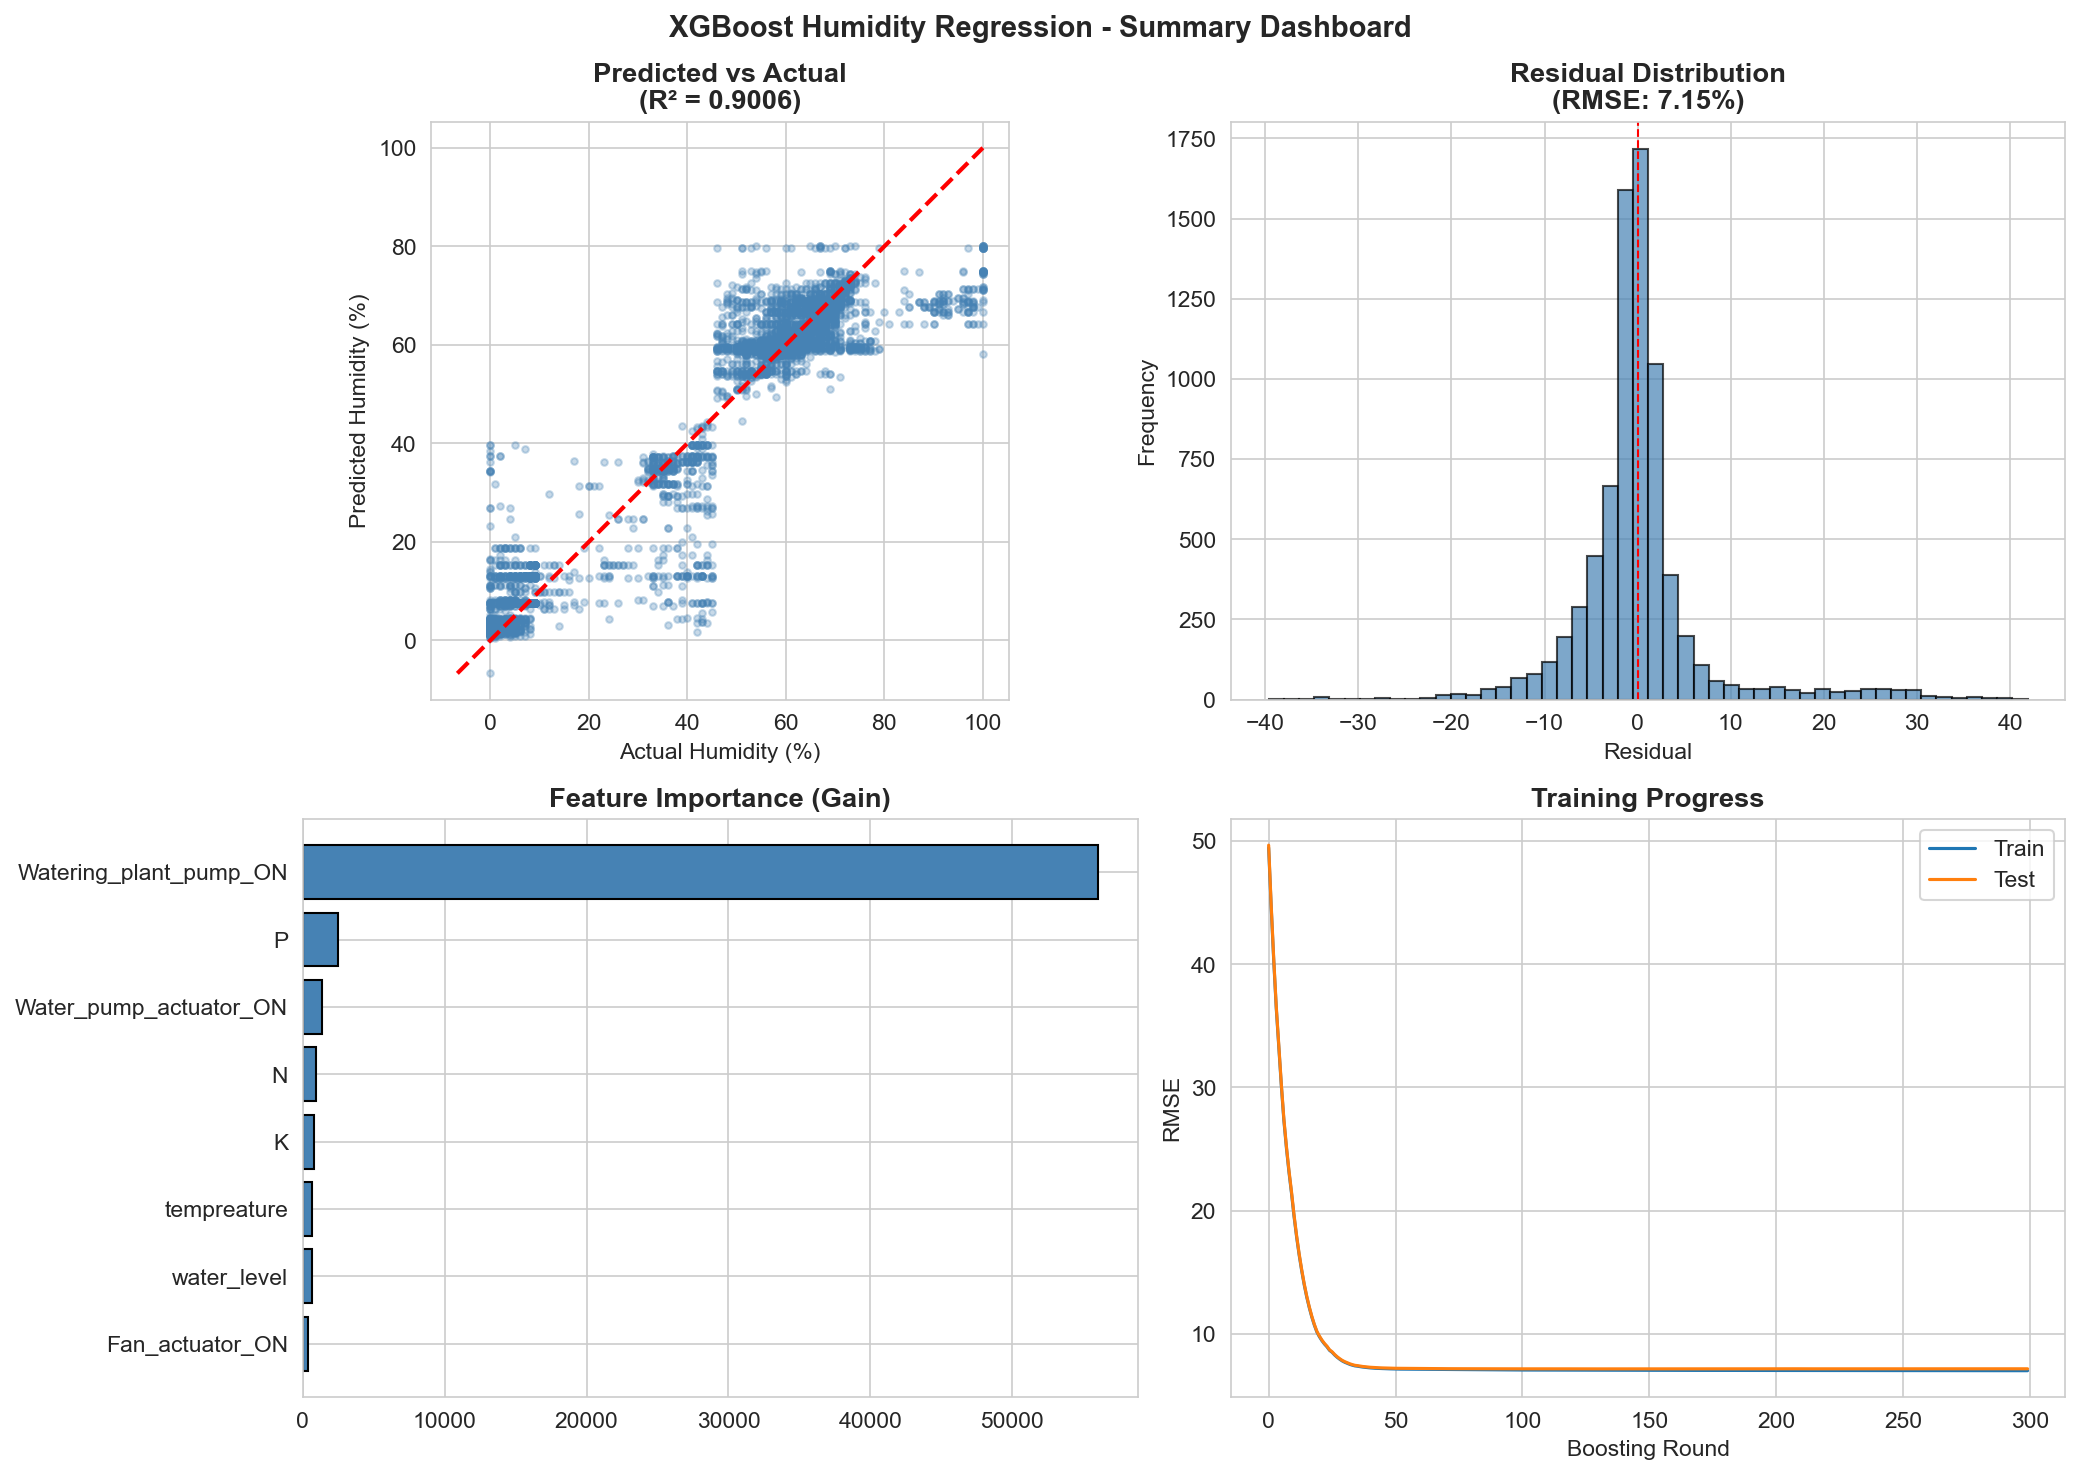

In [24]:
# Visualization 12: combined summary dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# top-left: predicted vs actual
axes[0, 0].scatter(y_test, y_pred, alpha=0.3, s=10, color='steelblue')
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 0].set_title(f'Predicted vs Actual\n(R² = {r2:.4f})', fontweight='bold')
axes[0, 0].set_xlabel('Actual Humidity (%)')
axes[0, 0].set_ylabel('Predicted Humidity (%)')
axes[0, 0].set_aspect('equal')

# top-right: residual distribution
axes[0, 1].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', lw=1)
axes[0, 1].set_title(f'Residual Distribution\n(RMSE: {rmse:.2f}%)', fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# bottom-left: feature importance
imp_sorted = importance_df.sort_values('Importance', ascending=True)
axes[1, 0].barh(imp_sorted['Feature'], imp_sorted['Importance'], 
                color='steelblue', edgecolor='black')
axes[1, 0].set_title('Feature Importance (Gain)', fontweight='bold')

# bottom-right: learning curve
axes[1, 1].plot(results['validation_0']['rmse'], label='Train')
axes[1, 1].plot(results['validation_1']['rmse'], label='Test')
axes[1, 1].set_title('Training Progress', fontweight='bold')
axes[1, 1].set_xlabel('Boosting Round')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend()

plt.suptitle('XGBoost Humidity Regression - Summary Dashboard', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('xgboost_dashboard.png', bbox_inches='tight')
plt.show()

## Conclusion

### Model Performance

The XGBoost regressor predicts greenhouse humidity from other sensor readings and actuator states. With 8 input features (temperature, water level, NPK nutrients, and 3 actuator ON/OFF states), it achieves an R² of ~0.90 and RMSE of about 7.15% humidity. Not perfect, but a solid result for a real-world sensor dataset.

### Key Findings

The feature importance analysis was probably the most informative part of this model. The watering pump state dominates everything else — which makes sense physically, since turning the pump on directly adds moisture to the environment. After that, phosphorus and the water pump actuator contribute, while temperature and water level play relatively minor roles.

The residual analysis shows the model struggles more at certain humidity ranges, which is expected since greenhouse environmental dynamics aren't perfectly linear. The Q-Q plot also shows some deviation from normality in the tails.

### IoT Deployment Considerations

XGBoost is a good fit for IoT edge deployment. Predictions take microseconds (much faster than running an LSTM), the saved model is compact compared to deep learning models, and you don't need a sequence buffer — just feed in the current sensor readings and get a prediction. One practical use case would be fault detection: if the predicted humidity starts diverging from the actual sensor reading, that could flag a malfunctioning sensor.

### Comparison with Model 1 (RNN)

| Aspect | Model 1 (RNN) | Model 2 (XGBoost) |
|--------|---------------|-------------------|
| Task | Time-series prediction | Regression from sensor state |
| Target | Sequential sensor value | Humidity (%) |
| Approach | Sequential deep learning | Gradient-boosted trees |
| Input | Historical sequence of readings | Current snapshot of all sensors |
| Strength | Captures temporal patterns | Fast, interpretable, lightweight |
| Deployment | Needs sequence buffer | Single-point prediction |
| Best for | Forecasting future values | Real-time sensor validation |

The two models complement each other well — the RNN handles the "what will happen next" question using temporal patterns, while XGBoost handles "is the current reading consistent with everything else" using cross-sensor relationships.